### Load the dataset from kaggle's data directory.
Check the working directory of kaggle's dataset and load its train dataset.

In [1]:
import os
os.listdir('/kaggle/input/feedback-prize-effectiveness')

['sample_submission.csv', 'train.csv', 'test.csv', 'test', 'train']

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV 


df_feeds = pd.read_csv("../input/feedback-prize-effectiveness/train.csv")
df_feeds['discourse_text'].isnull().sum() # checks for NAs

import string
string.punctuation 
import re
from nltk.corpus import stopwords
from collections import Counter
from itertools import chain

### Data pre-processing

Remove stopwords from corpus stopwords dictionary to prevent commonly used language or text such as 'a', 'the', etc, that may affect the predictive performance.

In [3]:
stop = set(stopwords.words('english')) 
df_feeds['discourse_text'].replace("[^a-zA-Z]"," ", regex=True, inplace =True)  # match strings that contains non-letter and replace with black to remove string.punctuations.
df_feeds['discourse_text'] = df_feeds['discourse_text'].str.lower() # converts strings to lower case.
print(df_feeds['discourse_text'])
df_feeds['discourse_text'] = df_feeds['discourse_text'].apply(lambda x: [item for item in str(x).split() if item not in stop])
freq = pd.Series(Counter(chain.from_iterable(df_feeds['discourse_text']))).sort_values(ascending=False) # count the frequencies of words.

0        hi  i m isaac  i m going to be writing about h...
1        on my perspective  i think that the face is a ...
2        i think that the face is a natural landform be...
3        if life was on mars  we would know by now  the...
4        people thought that the face was formed by ali...
                               ...                        
36760    for many people they don t like only asking on...
36761    also people have different views and opinions ...
36762    advice is something that can impact a persons ...
36763    someone can use everything that many people sa...
36764    in conclusion asking for an opinion can be ben...
Name: discourse_text, Length: 36765, dtype: object


#### Lemmatize all tokens into a new list to prevent overfitting of dataset when verb, nouns, adverb or adjectives are not as concerning on the impact of effectiveness of an argument.

In [4]:
import nltk
nltk.download('omw-1.4') #if error persist from ntlk libaries.
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import word_tokenize
wordnet_lem = WordNetLemmatizer()
df_feeds['discourse_text'] = df_feeds['discourse_text'].apply(
                    lambda lst:[wordnet_lem.lemmatize(word, pos='v') for word in lst])
df_feeds['discourse_text'] = df_feeds['discourse_text'].apply(
                    lambda lst:[wordnet_lem.lemmatize(word, pos='n') for word in lst])
df_feeds['discourse_text'] = df_feeds['discourse_text'].apply(
                    lambda lst:[wordnet_lem.lemmatize(word, pos='r') for word in lst])
df_feeds['discourse_text'] = df_feeds['discourse_text'].apply(
                    lambda lst:[wordnet_lem.lemmatize(word, pos='a') for word in lst])
freq_final = pd.Series(Counter(chain.from_iterable(df_feeds['discourse_text']))).sort_values(ascending=False)


[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


#### Visualize top 30 word frequencies. 

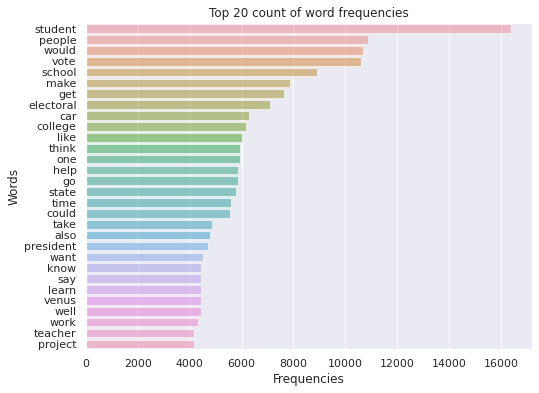

In [5]:
import seaborn as sns 
import matplotlib.pyplot as plt
top_words = freq_final.head(30).reset_index()

sns.reset_orig()
plt.figure(figsize = (8,6))
my_palette = sns.color_palette("colorblind") # variations of default palette: deep, muted, pastel, bright, dark, colorblind. 
plt.style.use('seaborn-colorblind')
sns.set(rc={'figure.figsize':(10,5)})
sns.barplot(x=top_words.iloc[:,1], y=top_words.iloc[:,0],data=top_words , alpha = 0.6).set_title('Top 20 count of word frequencies')
plt.xlabel('Frequencies')
plt.ylabel('Words')
plt.show()

#### Visualize the dataset to determine if data is normal distributed.

In [6]:
counts = df_feeds.discourse_effectiveness.value_counts()
print(counts)
print("\nPredicting only 0 = {:.2f}% accuracy".format(counts[0] / sum(counts) * 100))
print("\nPredicting only 1 = {:.2f}% accuracy".format(counts[1] / sum(counts) * 100))
print("\nPredicting only 2 = {:.2f}% accuracy".format(counts[2] / sum(counts) * 100))

Adequate       20977
Effective       9326
Ineffective     6462
Name: discourse_effectiveness, dtype: int64

Predicting only 0 = 57.06% accuracy

Predicting only 1 = 25.37% accuracy

Predicting only 2 = 17.58% accuracy


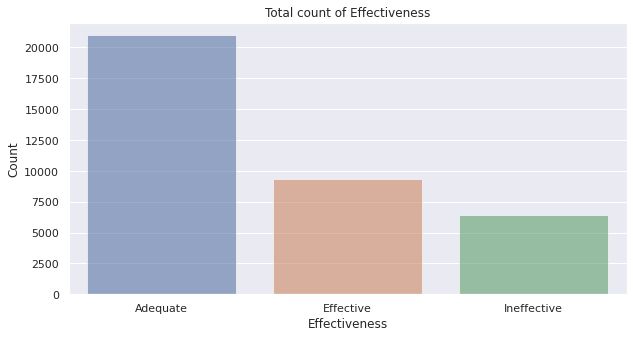

In [7]:
df_counts = pd.DataFrame(counts).reset_index()
plt.figure(figsize = (10,5))
sns.barplot(x=df_counts['index'],y=df_counts['discourse_effectiveness'],data=df_counts,alpha = 0.6).set_title('Total count of Effectiveness')
plt.xlabel('Effectiveness')
plt.ylabel('Count')
plt.show()

It can be observed that there are more Adequate feedbacks than Effective and Ineffective, indicating that the data may be imbalanced and may be prone to lower prediction accuracy. 

#### One-hot-encoding by creating dummies to categorical data.

In [8]:
df_effects = pd.get_dummies(df_feeds.iloc[:,4])
df_feeds = pd.concat([df_feeds, df_effects], axis=1) # combine dummy rows.

#### Train-test validation approach.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df_feeds['discourse_text'].values, df_feeds[['Adequate', 'Effective','Ineffective']].values, stratify=df_feeds['discourse_effectiveness'],test_size=0.1, random_state=100)

#### Tokenize 500 most common words to prevent overftitting from noise text that least occur.

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=500, oov_token='x')
word_index = tokenizer.word_index
count_words = tokenizer.word_counts
tokenizer.fit_on_texts(X_train) 
tokenizer.fit_on_texts(X_test)
seq_train = tokenizer.texts_to_sequences(X_train)
seq_test = tokenizer.texts_to_sequences(X_test)
pad_train = pad_sequences(seq_train) 
pad_test = pad_sequences(seq_test)

#### Shuffle train set after splitting to improve or avoid overfitting and ensure data are representatives.


In [11]:
from sklearn.utils import shuffle
pad_train, y_train = shuffle(pad_train, y_train)
print(pad_train[9])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

### Creating LST model to predict effectiveness of arguments.
Create LST model and add neuron layers to easily define relationship of the output classess. Last layer based on number of desired categorical/classes output of interest.

Linear regularization used in optimizer settings to prevent overfitting of data.

In [12]:
import tensorflow as tf
from tensorflow.keras import regularizers
import keras
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential 
import tensorflow
from tensorflow.keras.layers import Dropout

# Create LST model and add neuron layers to easily define relationship of the output classess. Last layer based on number of desired categorical/classes output of interest.
# Linear regularization used in optimizer settings to prevent overfitting of data.
lst_mod = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=3000, output_dim=100),
    tf.keras.layers.SpatialDropout1D(0.3),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
lst_mod.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
lst_mod.summary()

2022-08-02 15:24:13.512042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-02 15:24:13.622872: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-02 15:24:13.623721: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-02 15:24:13.625726: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         300000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 100)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1

#### Implementing early stopper to prevent overfitting of data that may occur on validation accuracy.


In [13]:
class earlystop(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}): 
    if(logs.get('val_accuracy')>0.855):
      print("Accuracy has reached > 85.5%!") 
      self.model.stop_training = True
es = earlystop() 

After numerous trial runs, epochs = 20 provides constant increase in test accuracy. If epochs > 20, LST model may overfit, where train accuracy graduaually increasing while validation accuracy decreases.

In [14]:
lst_mod1 = lst_mod.fit(pad_train, y_train, epochs=20, callbacks=[es],
            validation_data=(pad_test, y_test), verbose=1, batch_size=100)

2022-08-02 15:24:16.991297: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-08-02 15:24:19.504600: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


331/331 [==============================] - 14s 30ms/step - loss: 0.9029 - accuracy: 0.6098 - val_loss: 0.8523 - val_accuracy: 0.6258
Epoch 2/20
331/331 [==============================] - 10s 30ms/step - loss: 0.8376 - accuracy: 0.6305 - val_loss: 0.8301 - val_accuracy: 0.6329
Epoch 3/20
331/331 [==============================] - 10s 29ms/step - loss: 0.8150 - accuracy: 0.6374 - val_loss: 0.8167 - val_accuracy: 0.6331
Epoch 4/20
331/331 [==============================] - 10s 29ms/step - loss: 0.8087 - accuracy: 0.6384 - val_loss: 0.8167 - val_accuracy: 0.6380
Epoch 5/20
331/331 [==============================] - 10s 29ms/step - loss: 0.7981 - accuracy: 0.6439 - val_loss: 0.8132 - val_accuracy: 0.6440
Epoch 6/20
331/331 [==============================] - 10s 29ms/step - loss: 0.7882 - accuracy: 0.6491 - val_loss: 0.8089 - val_accuracy: 0.6440
Epoch 7/20
331/331 [==============================] - 10s 29ms/step - loss: 0.7838 - accuracy: 0.6506 - val_loss: 0.8141 - val_accuracy: 0.6435
Epo

##### Visualize overview accuracy and validation accuracy of individual epochs of the LST model.

###### Note: Saving LST model into a variable allows the model to be visualized on graph, else it would return an error where history is not callable.

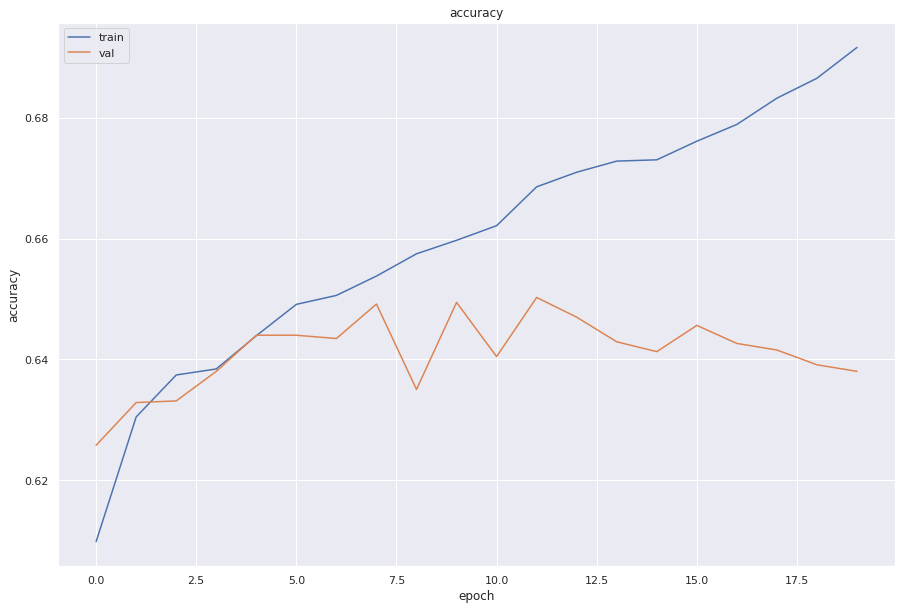

In [15]:
plt.figure(figsize = (15,10))
plt.plot(lst_mod1.history['accuracy'])
plt.plot(lst_mod1.history['val_accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##### Predict LST model on padded test set.

In [16]:
y_predict = lst_mod.predict(pad_test, verbose=0)
print(y_predict)

[[0.6803066  0.00556754 0.31412587]
 [0.728417   0.11794535 0.15363768]
 [0.7483122  0.05025303 0.20143478]
 ...
 [0.85462755 0.06120837 0.08416406]
 [0.4116303  0.58673114 0.00163853]
 [0.7079885  0.19127648 0.10073506]]


#### Confusion matrix 

In [17]:
import sklearn.metrics as metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
test_cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_predict.argmax(axis=1))
print(test_cm)
test_score = metrics.accuracy_score(y_test.argmax(axis=1), y_predict.argmax(axis=1))
print(test_score)
test_report = metrics.classification_report(y_test.argmax(axis=1), y_predict.argmax(axis=1))
print(test_report)


[[1763  243   92]
 [ 448  472   13]
 [ 498   37  111]]
0.6380201251019854
              precision    recall  f1-score   support

           0       0.65      0.84      0.73      2098
           1       0.63      0.51      0.56       933
           2       0.51      0.17      0.26       646

    accuracy                           0.64      3677
   macro avg       0.60      0.51      0.52      3677
weighted avg       0.62      0.64      0.61      3677



It can be seen that basesd on classification report, 0: 'Adequate' has the highest overall accuracy in terms of precision (actual true positive ouf of predicted positive), recall (true positive rate) and f1-score (mean of precision and recall, taking consideration of false positive and false negatives)

It can also be observed that 'Adequate' has the highest number of observations supporting its accuracy.

Followed by 1:'Effective' with the second highest accuracy and 2: 'Ineffective' as the least overall accuracy. 


#### Visualize Confusion Matrix

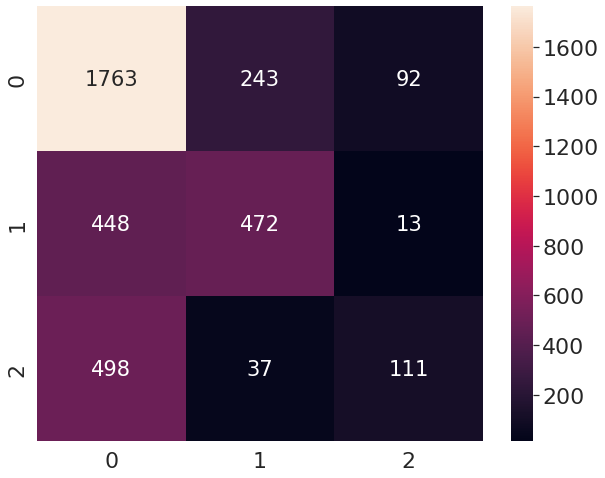

In [18]:
test_cm = pd.DataFrame(test_cm, range(3), range(3))
plt.figure(figsize = (10,8))
sns.set(font_scale=2)
sns.heatmap(test_cm, annot=True, annot_kws={"size": 21},fmt='d')
plt.show()

#### Rename columns and Export final test.csv dataset for submission.


In [19]:
df_test_predict = pd.DataFrame(y_predict, columns=['Adequate','Effective','Ineffective'])
final_test_dataset = pd.merge(df_feeds, df_test_predict, how = 'right', left_index= True ,right_index =True)
final_test_dataset = final_test_dataset[['discourse_id', 'Adequate_y', 'Effective_y','Ineffective_y']]
final_test_dataset.rename(columns={'Adequate_y' : 'Adequate', 'Effective_y' : 'Effective', 'Ineffective_y' : 'Ineffective'}, inplace=True)
final_test_dataset.to_csv('test_submission.csv', index=False)
print(final_test_dataset)

      discourse_id  Adequate  Effective  Ineffective
0     0013cc385424  0.680307   0.005568     0.314126
1     9704a709b505  0.728417   0.117945     0.153638
2     c22adee811b6  0.748312   0.050253     0.201435
3     a10d361e54e4  0.087361   0.912479     0.000160
4     db3e453ec4e2  0.593463   0.051603     0.354933
...            ...       ...        ...          ...
3672  643277623c55  0.004026   0.995942     0.000032
3673  f315ff556868  0.375927   0.618319     0.005754
3674  7a3aef0cfc2d  0.854628   0.061208     0.084164
3675  09cc9d107416  0.411630   0.586731     0.001639
3676  13290ff2b629  0.707989   0.191276     0.100735

[3677 rows x 4 columns]
